# Explore `multi-level variable`

In [1]:
import os
import json 
import subprocess
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

import xbitinfo as xb
import xarray as xr

/home/datacomp/miniconda3/envs/bitinfo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

---

In [3]:
# load data
path_to_data = '../data2/cams_hej6_pl_q_20191201.nc'  # change this
ds = xr.open_dataset(path_to_data)
# ds = ds_all.isel(time=0)

In [4]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, level: 8, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * level      (level) int32 10 50 100 200 500 700 850 1000
  * time       (time) datetime64[ns] 2019-12-01T12:00:00
Data variables:
    q          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-20 10:48:32 GMT by grib_to_netcdf-2.30.2: grib_to_n...

fig, ax = plt.subplots(figsize=(15, 7))
ds.isel(level=0)['t'].plot(ax=ax)

fig, ax = plt.subplots(figsize=(15, 7))
ds.isel(level=5)['t'].plot(ax=ax)

xb.plot_distribution(ds)

---

In [5]:
# get information content per bit
info_per_bit = xb.get_bitinformation(ds, dim='latitude', implementation="python")

Processing var: q for dim: latitude: 100%|████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


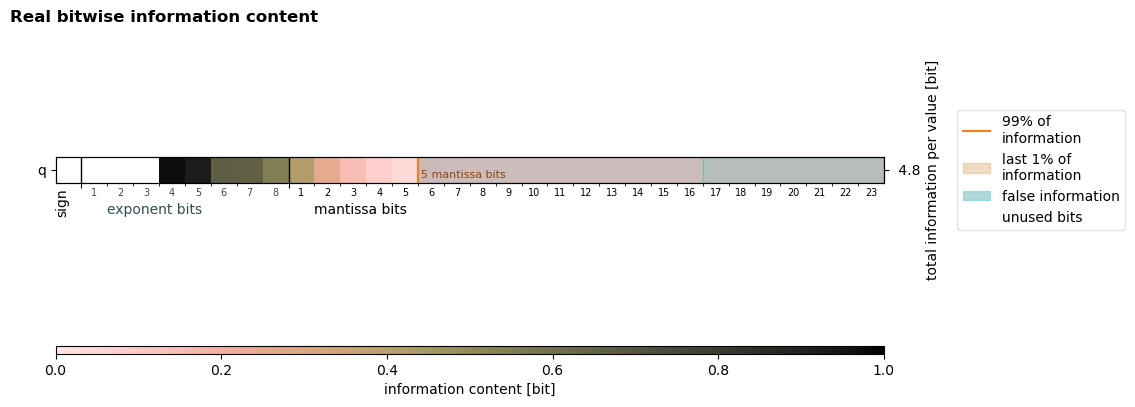

In [6]:
fig = xb.plot_bitinformation(info_per_bit)

---

In [7]:
at_least_zero = lambda x: max(x, 0)

chunk_long, chunk_lat = [100, 41] # for int division
vrbs = ['longitude', 'latitude']
var = 'latitude'

dss = {}
dss_bitrounded = {}
dss_kbits = {}

long_c = int(ds.longitude.size / chunk_long)
lat_c = int(ds.latitude.size / chunk_lat)
lvl_c = int(ds.level.size)

for l in range(lvl_c):
    
    dss[l] = []
    dss_bitrounded[l] = []
    dss_kbits[l] = []
    
    for i in range(long_c):
        for j in range(lat_c):
            ds_lvl = ds.isel(level=l)
            temp_ds = ds_lvl.isel(longitude=slice(i*chunk_long, (i+1)*chunk_long),
                                  latitude=slice(j*chunk_lat, (j+1)*chunk_lat))
            dss[l].append(temp_ds)
            temp_info_pbit = xb.get_bitinformation(temp_ds, dim=var, implementation="python")
            temp_keepbits = xb.get_keepbits(temp_info_pbit, 0.99)
            # temp_keepbits = temp_keepbits.map(at_least_zero)
            dss_kbits[l].append(temp_keepbits)
            temp_ds_bitrounded = xb.xr_bitround(temp_ds, temp_keepbits)
            dss_bitrounded[l].append(temp_ds_bitrounded)

Processing var: q for dim: latitude: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]


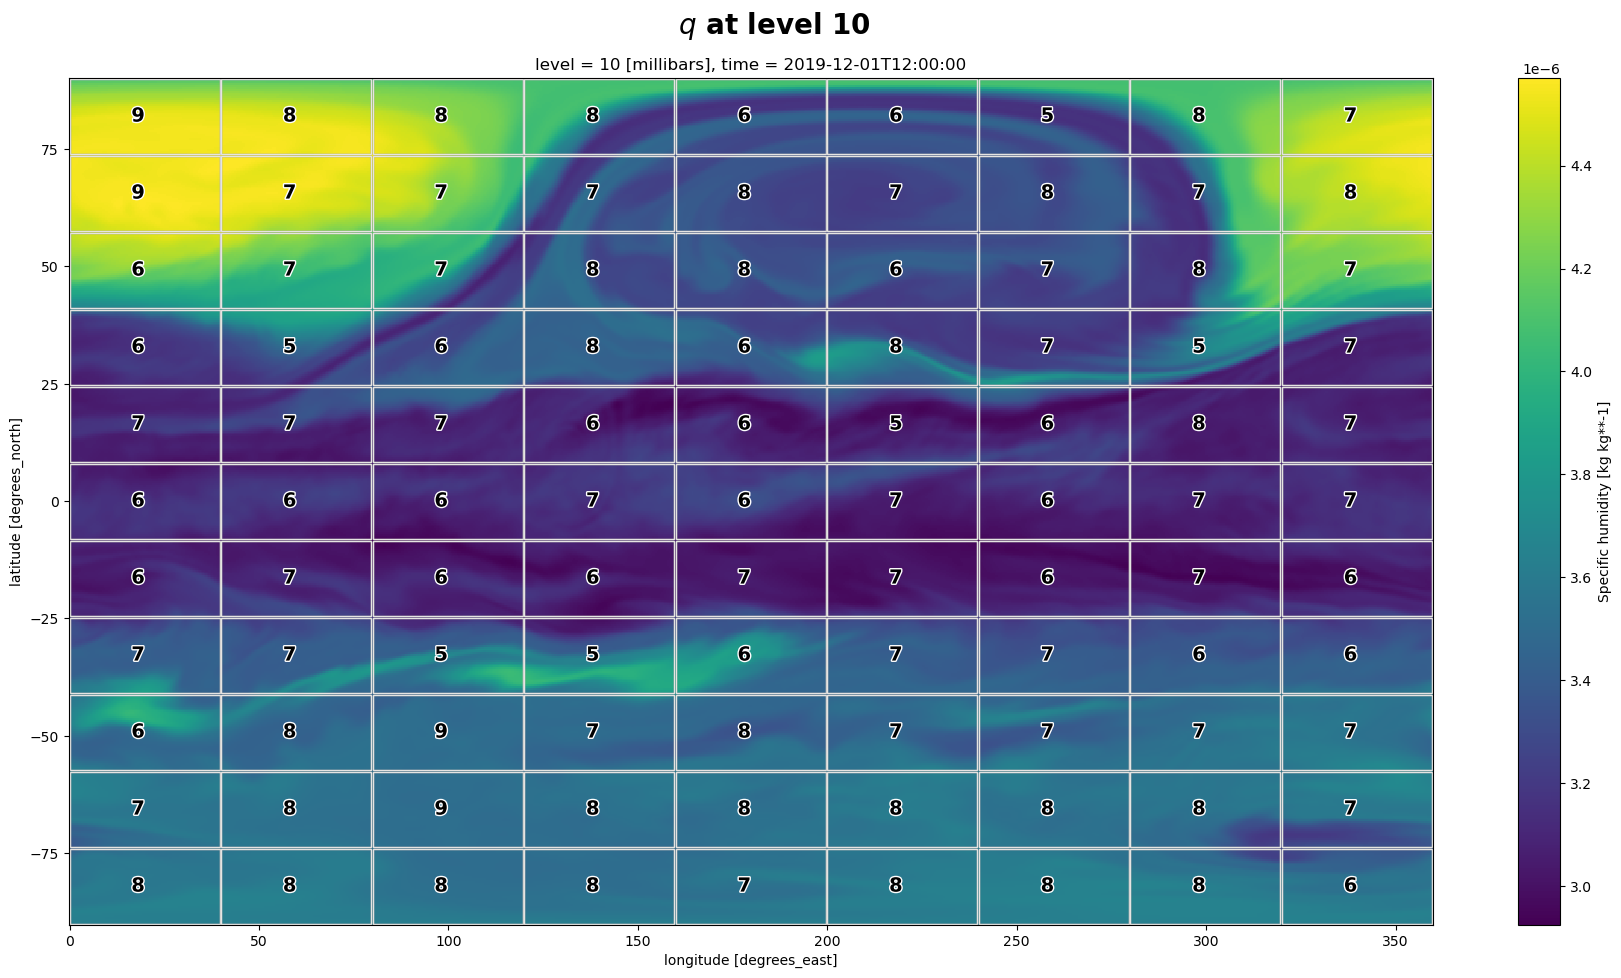

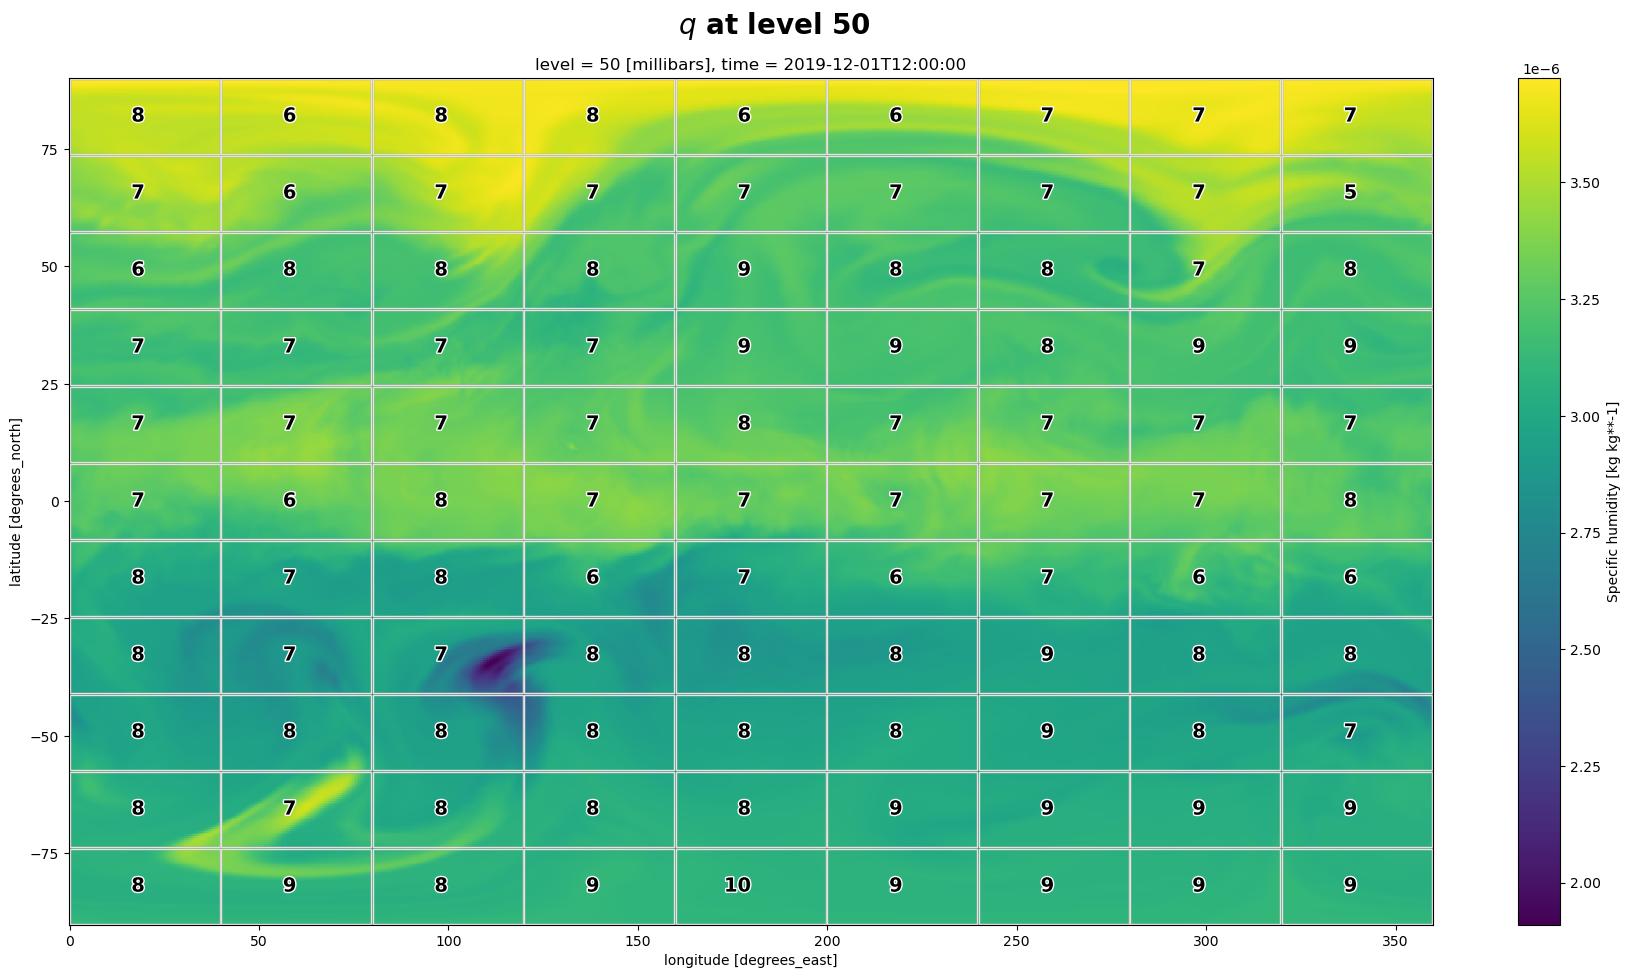

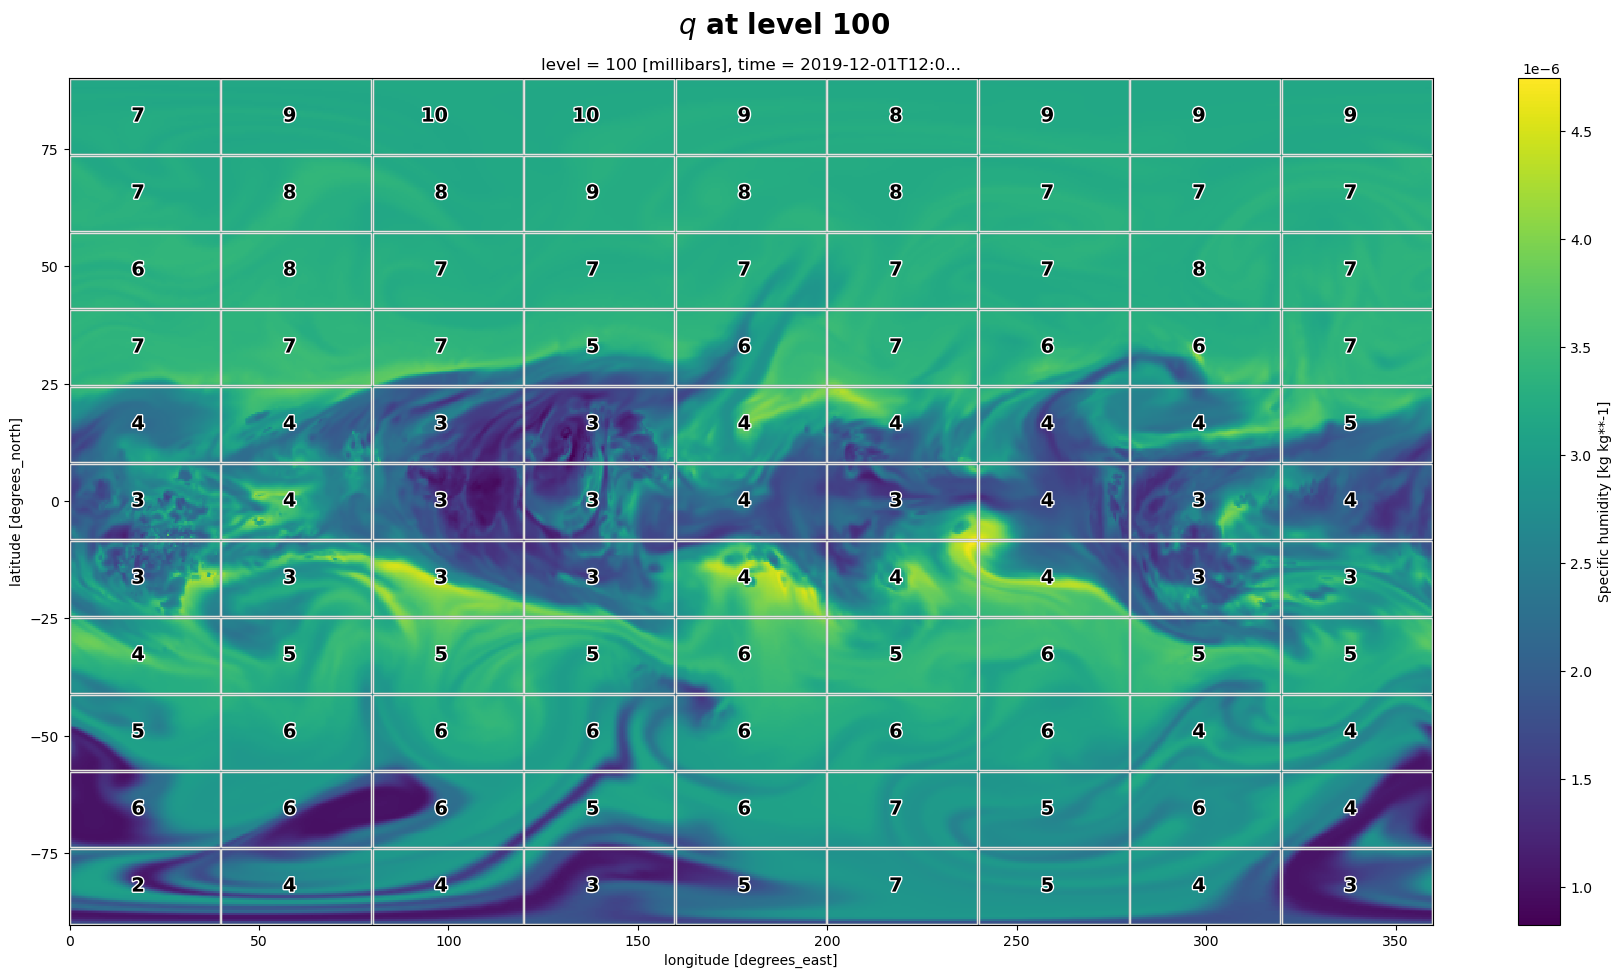

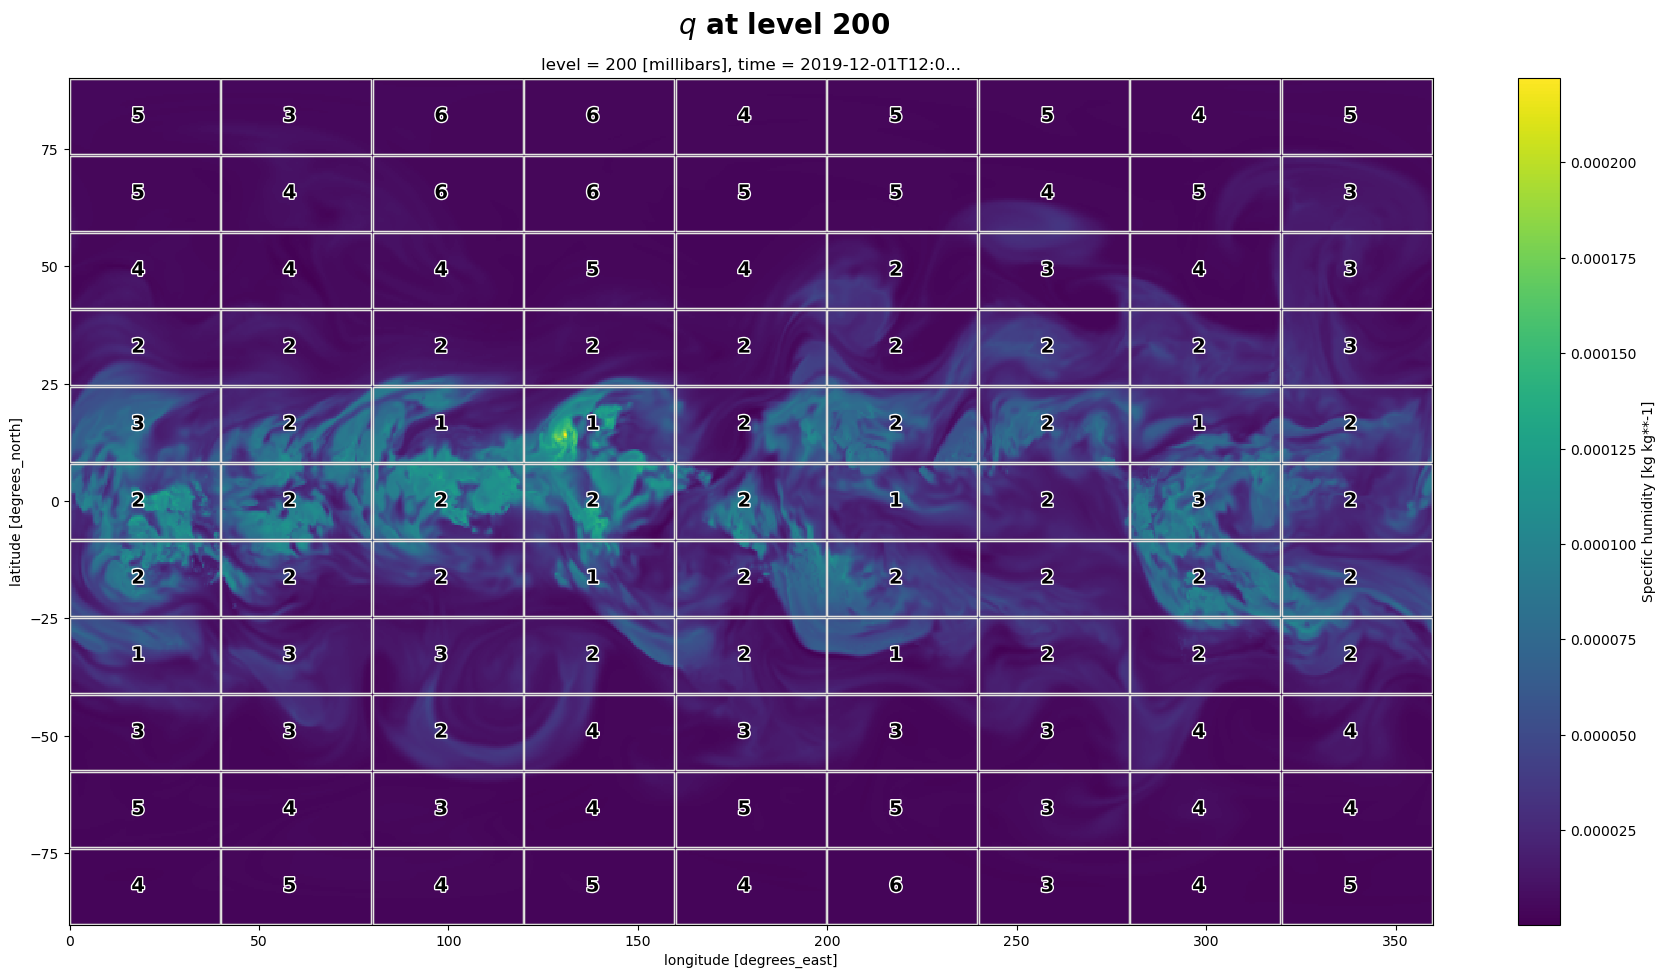

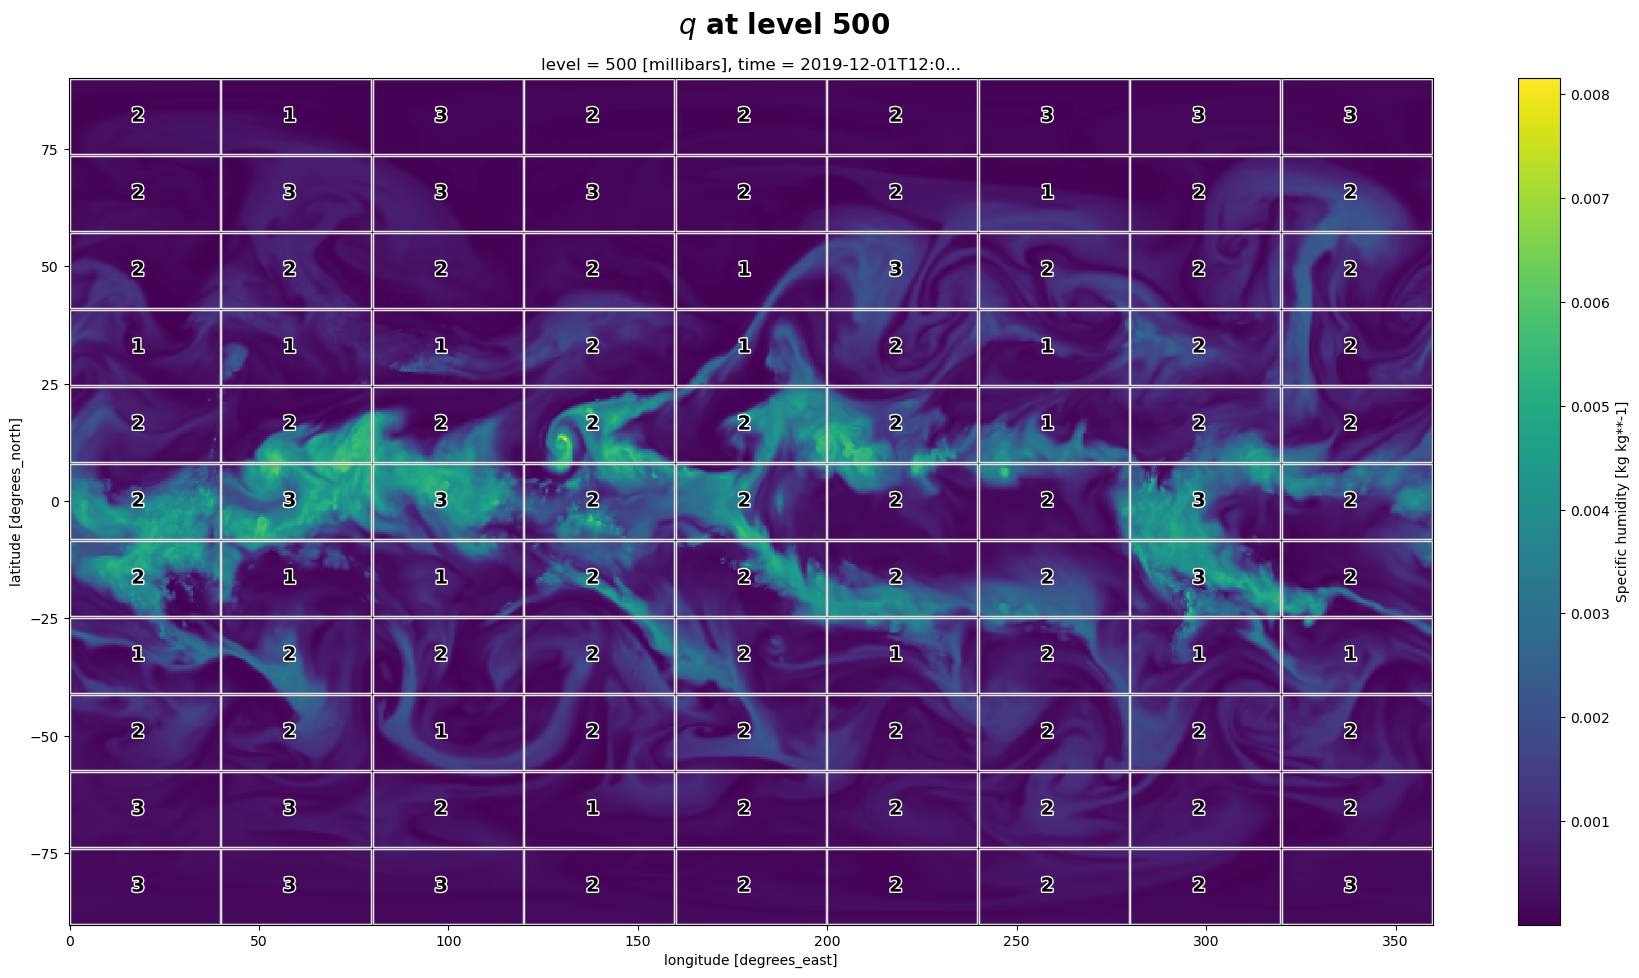

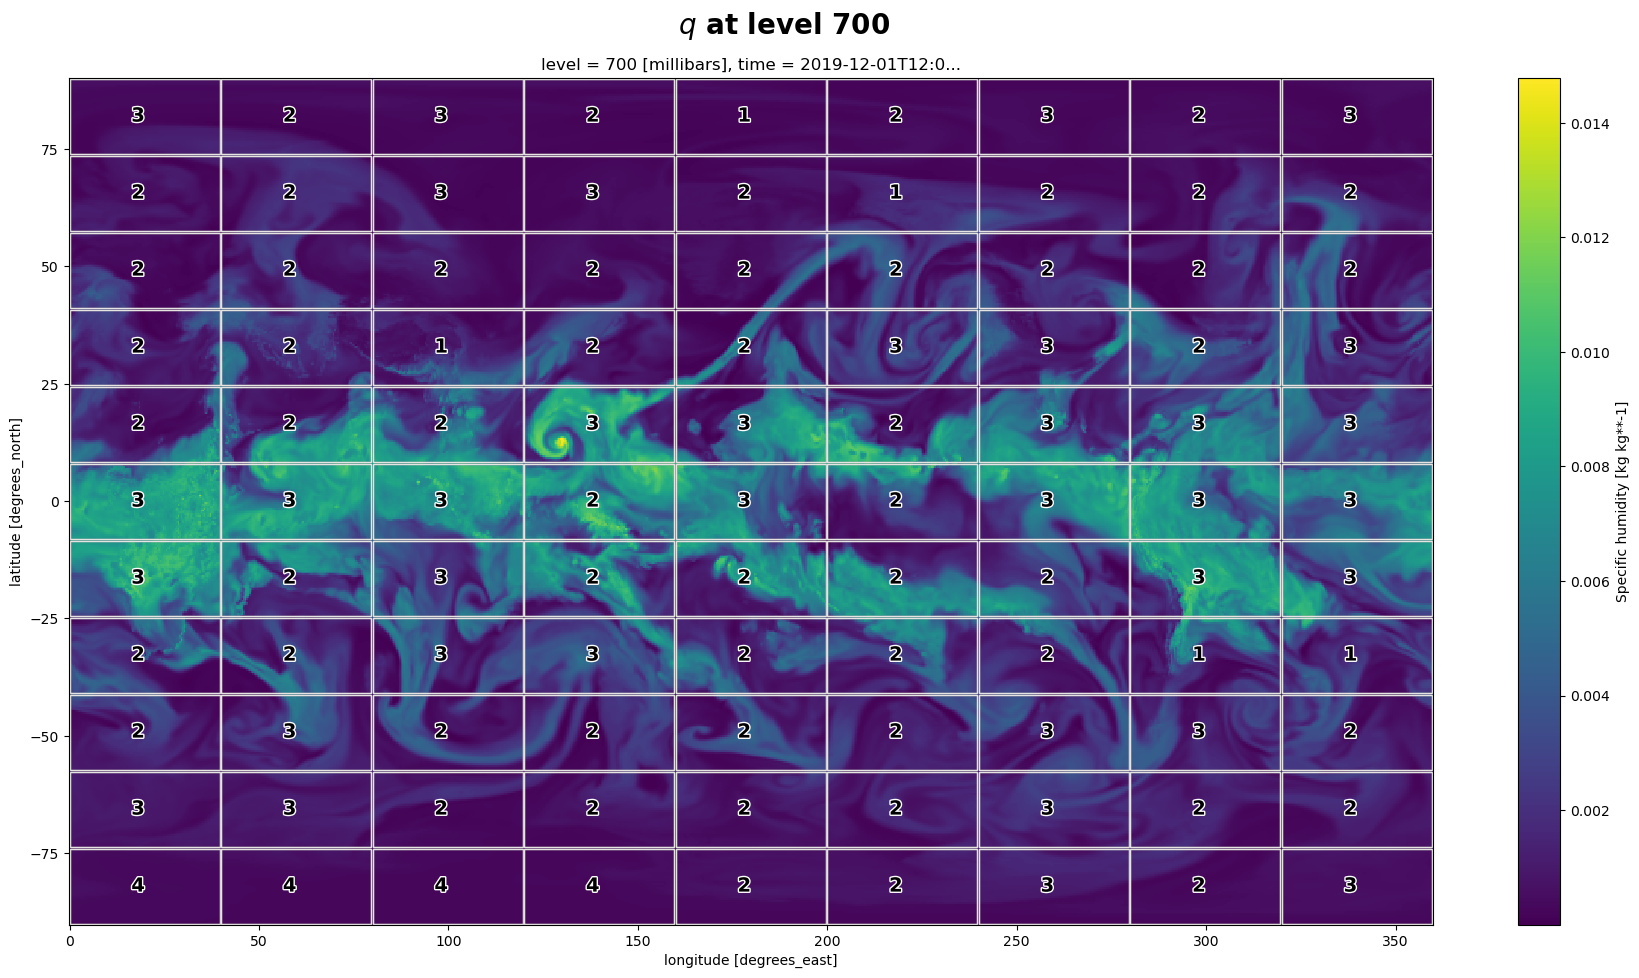

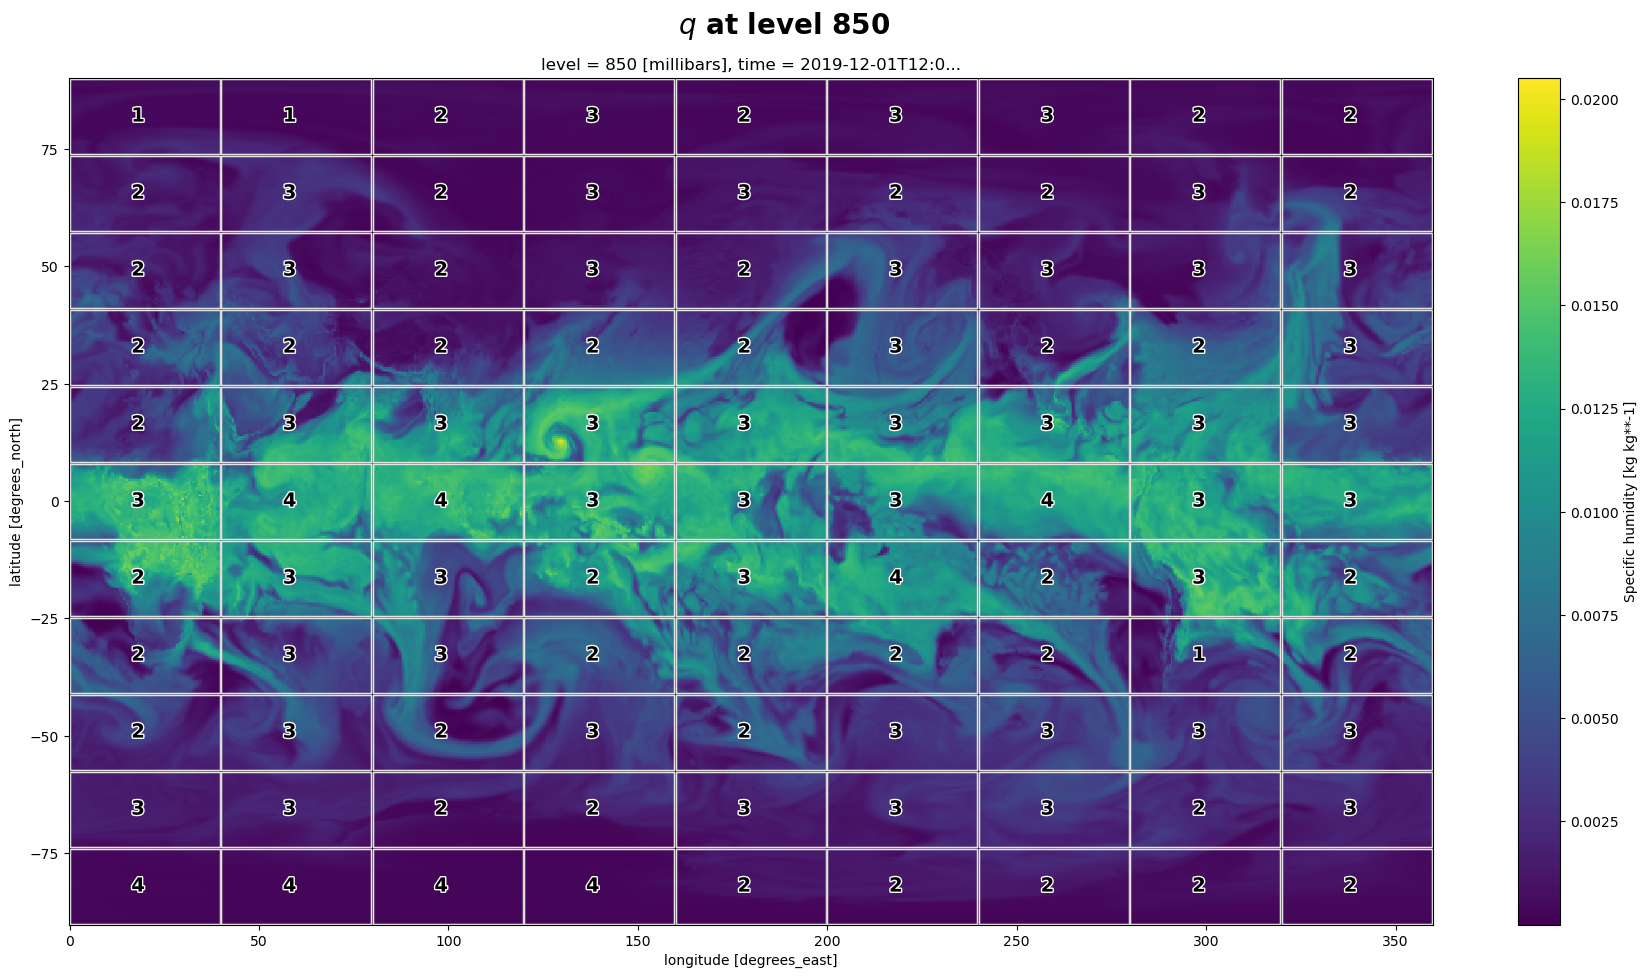

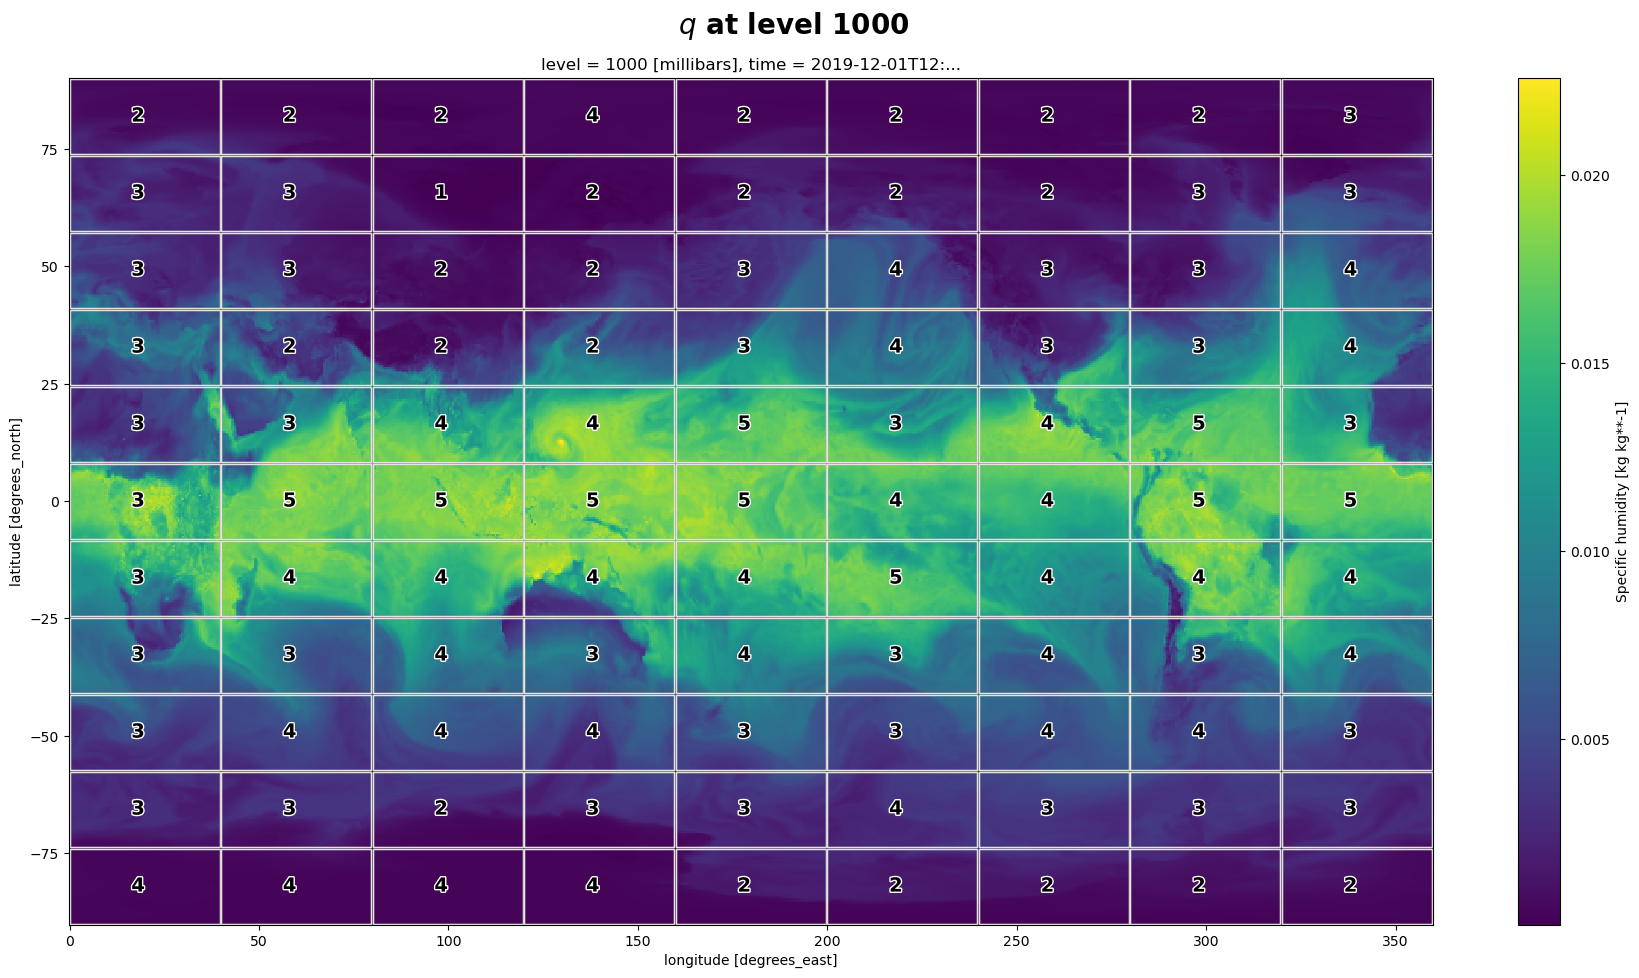

In [8]:
for l in range(lvl_c):
    
    fig, ax = plt.subplots(figsize=(22, 11))

    ds.isel(level=l)['q'].plot(ax=ax)

    for i in range(len(dss_bitrounded[l])):
        lats = dss[l][i].latitude
        longs = dss[l][i].longitude
        
        x = float(min(longs[0], longs[-1]))
        y = float(min(lats[0], lats[-1]))
        w = float(abs(longs[0] - longs[-1]))
        h = float(abs(lats[0] - lats[-1]))
        
        rect = mpl.patches.Rectangle((x, y), width = w, height = h,
                                    facecolor = "none", edgecolor = "#E5E4E2",
                                    path_effects=[pe.withStroke(linewidth=1, foreground="gray")],
                                    label='xxx')
        ax.add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate(
            f"""
            {int(dss_kbits[l][i].q):2}
            """,
            (cx, cy), color='k', weight='bold', fontsize=14, ha='right', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='w')]
        )
    
    level = int(dss_bitrounded[l][0].level)
    fig.text(.402, .92, f'$q$ at level {level}', weight='bold', fontsize=20)

    fig.show()

In [9]:
import pandas as pd

In [10]:
for l in range(lvl_c):
    level = int(dss_bitrounded[l][0].level)
    data = [[int(i) for i in list(dss_kbits[l][j].to_array().data)] for j in range(len(dss_kbits[l]))]
    df = pd.DataFrame(data=data,
                      columns=[f'q-{level}'])
    if l == 0: df_all = df
    else: df_all = df_all = pd.concat([df_all, df], axis=1)

/tmp/ipykernel_10262/2627920940.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(dss_kbits[l][j].to_array().data)] for j in range(len(dss_kbits[l]))]
/tmp/ipykernel_10262/2627920940.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(dss_kbits[l][j].to_array().data)] for j in range(len(dss_kbits[l]))]
/tmp/ipykernel_10262/2627920940.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for

In [11]:
df_all

q-10  q-50  q-100  q-200  q-500  q-700  q-850  q-1000
0      9     8      7      5      2      3      1       2
1      9     7      7      5      2      2      2       3
2      6     6      6      4      2      2      2       3
3      6     7      7      2      1      2      2       3
4      7     7      4      3      2      2      2       3
..   ...   ...    ...    ...    ...    ...    ...     ...
94     6     6      3      2      2      3      2       4
95     6     8      5      2      1      1      2       4
96     7     7      4      4      2      2      3       3
97     7     9      4      4      2      2      3       3
98     6     9      3      5      3      3      2       2

[99 rows x 8 columns]

In [12]:
df_all.describe()

q-10       q-50      q-100      q-200      q-500      q-700  \
count  99.000000  99.000000  99.000000  99.000000  99.000000  99.000000   
mean    6.989899   7.595960   5.555556   3.161616   2.010101   2.383838   
std     0.974103   0.957454   1.907141   1.375493   0.597528   0.650072   
min     5.000000   5.000000   2.000000   1.000000   1.000000   1.000000   
25%     6.000000   7.000000   4.000000   2.000000   2.000000   2.000000   
50%     7.000000   8.000000   6.000000   3.000000   2.000000   2.000000   
75%     8.000000   8.000000   7.000000   4.000000   2.000000   3.000000   
max     9.000000  10.000000  10.000000   6.000000   3.000000   4.000000   

           q-850     q-1000  
count  99.000000  99.000000  
mean    2.606061   3.252525  
std     0.682405   0.940510  
min     1.000000   1.000000  
25%     2.000000   3.000000  
50%     3.000000   3.000000  
75%     3.000000   4.000000  
max     4.000000   5.000000

In [13]:
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_10262/2414357448.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


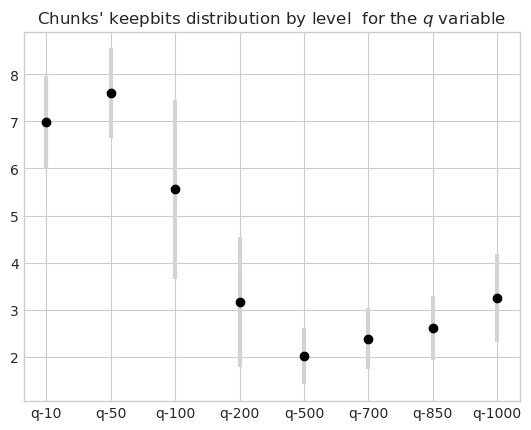

In [14]:
plt.errorbar(list(df_all.columns), df_all.mean().values, yerr=df_all.std().values,
             fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
plt.title(f'Chunks\' keepbits distribution by level  for the ${list(ds.keys())[0]}$ variable')
plt.show()

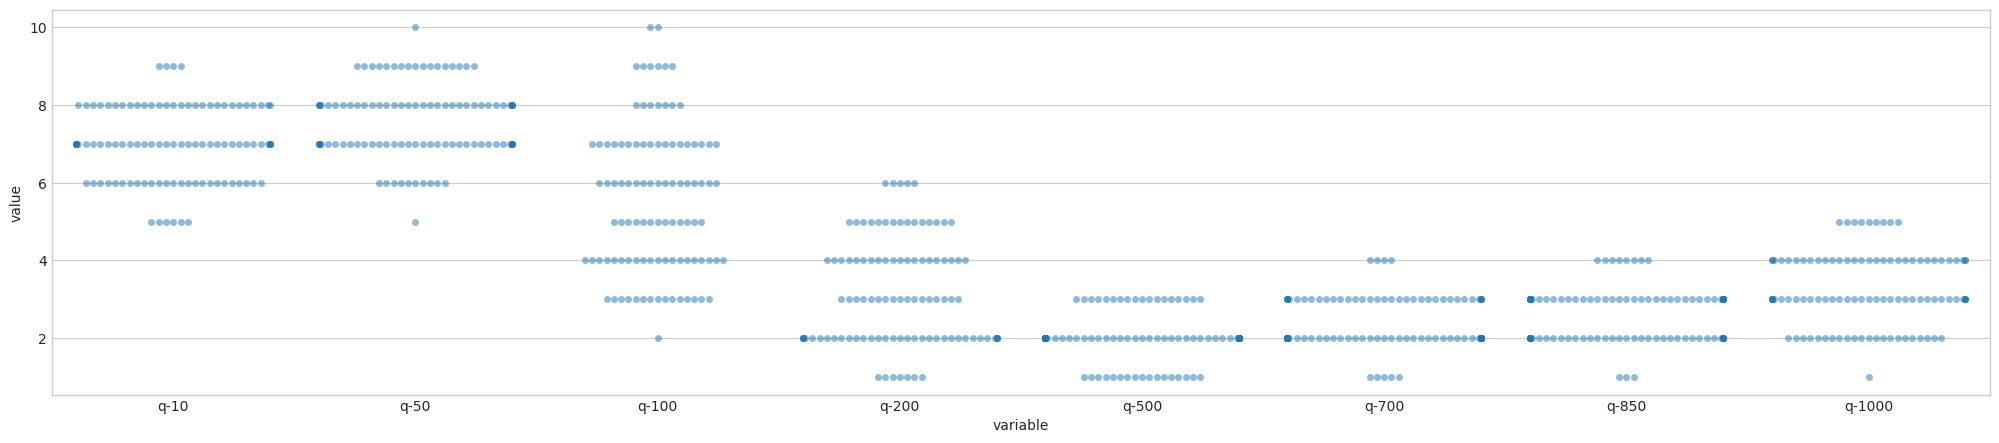

In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(25,5))
sns.swarmplot(x="variable", y="value", data=df_all.melt(), ax=ax, alpha=.5)
plt.show()

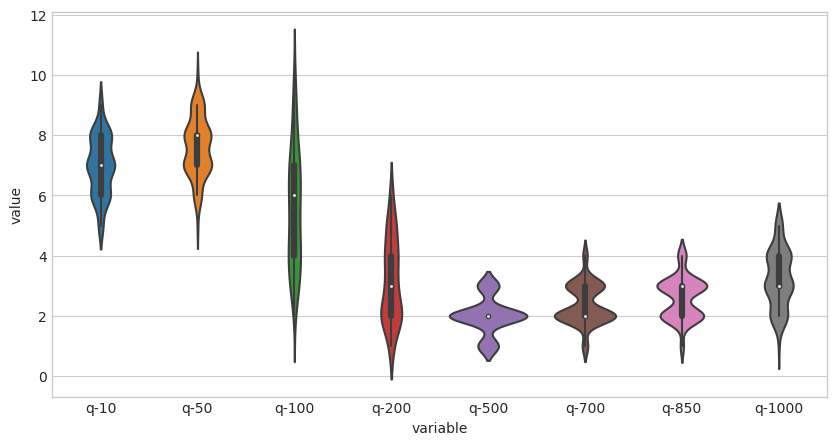

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
sns.violinplot(x="variable", y="value", data=df_all.melt(), ax=ax)
plt.show()

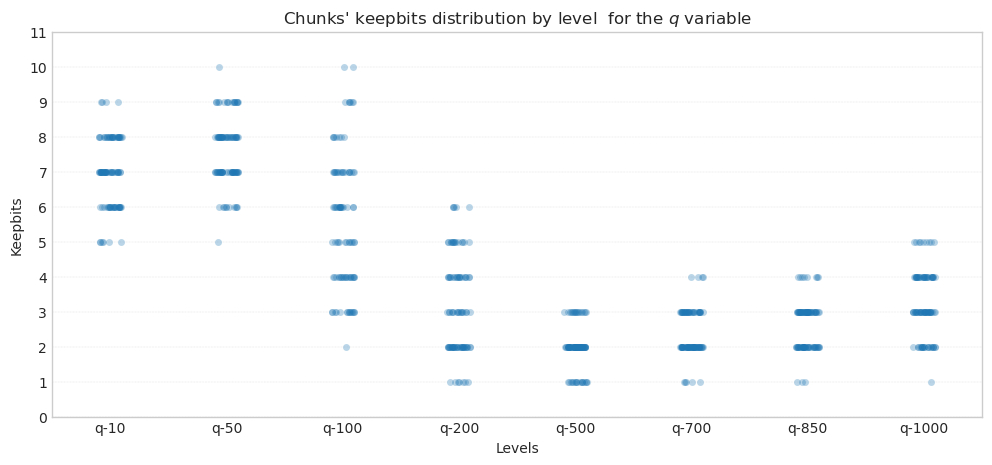

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
sns.stripplot(x="variable", y="value", data=df_all.melt(), ax=ax, alpha=.3)
ax.set_xlabel('Levels')
ax.set_ylabel('Keepbits')
ax.set_yticks(list(range(12)))
ax.grid(linestyle='-.', linewidth=.2, axis='y')
ax.set_title(f'Chunks\' keepbits distribution by level  for the ${list(ds.keys())[0]}$ variable')
plt.show()